Sentiment Analysis using LSTM with pretrained GloVe model on custome dataset

In [402]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [403]:
pashtoText= pd.read_csv('PashtoCorpusUpdated.csv')

In [404]:
pashtoText.head()

,Id,Source,Topic,PashtoText,EnglishtTranslation,AnnotatorOne,AnnotatorTwo
0,1,https://www.facebook.com/167959249906191/posts...,افغان ولسمشر محمد اشرف غني ویلي، په اوسنیو شرا...,د لیوني څخه پوښتنه د یو لیونی څخه یو چا پوښتنه...,Question from a madman Someone asked that grie...,Negative,Negative
1,2,NaN,Afghan President Mohammad Ashraf Ghani said th...,جهالت د نابالغه ماشومانو په باچا پورې خندل نه...,"Ignorance of immature children ,If you don't l...",Positive,Positive
2,3,NaN,NaN,ماته خو بی خوبه خکاری نور نه پو هیږم,I like it but I don't know anymore,Positive,Positive
3,4,NaN,NaN,عنى ځان لپاره عمحوار دى نه د وطن حلکو لپاره دا...,Ghani is a leader for himself and not for the ...,Negative,Negative
4,5,NaN,NaN,خپله سه بلا وهلي یی ړوزي خو نه دي چي کوي یی,what happened with you. This is not joking tha...,Negative,Negative


In [405]:
pashtoText.drop(["Id","Source", "Topic", "PashtoText", "AnnotatorTwo"], axis=1, inplace=True)

In [406]:
pashtoText.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   EnglishtTranslation  600 non-null    object
 1   AnnotatorOne         600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [407]:
# # covert string into numerical of reviewe attr
labels = {"Positive": 1, "Negative": 0}
pashtoText['AnnotatorOne'] = pashtoText['AnnotatorOne'].map(labels)
pashtoText.head()

,EnglishtTranslation,AnnotatorOne
0,Question from a madman Someone asked that grie...,0
1,"Ignorance of immature children ,If you don't l...",1
2,I like it but I don't know anymore,1
3,Ghani is a leader for himself and not for the ...,0
4,what happened with you. This is not joking tha...,0


In [409]:
from nltk.corpus import stopwords # to remove the stopwrods
from nltk.stem.porter import PorterStemmer # steam to root word every
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
import re
steamer = PorterStemmer()

In [410]:
# clean the text data
def preprocessText(text):
    # remove non-alphabetic characters
    text = re.sub('[^A-Za-z]', ' ', text)
    # convert to lowercase
    text = text.lower()
    # remove stopwords
    stopWords = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if not word in stopWords]
    # join the words back into a string
    text = ' '.join(words)
    return text

In [411]:
x = []
words = list(pashtoText['EnglishtTranslation'])
for i in words:
    x.append(preprocessText(i))

In [412]:
x[:3]

['question madman someone asked grief good happy important thing pots food said madman',
 'ignorance immature children laugh king ghani pride ghani leader ghani mourner country',
 'like know anymore']

In [413]:
y = pashtoText['AnnotatorOne']
y

0      0
1      1
2      1
3      0
4      0
      ..
595    0
596    1
597    1
598    1
599    1
Name: AnnotatorOne, Length: 600, dtype: int64

In [414]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing set
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [415]:
from keras.preprocessing.text import Tokenizer
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xTrain)

In [416]:
xTrain = tokenizer.texts_to_sequences(xTrain)
xTest = tokenizer.texts_to_sequences(xTest)

In [417]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocabLen = len(tokenizer.word_index) + 1
vocabLen 

1079

In [418]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 50
xTrain = pad_sequences(xTrain, padding='post', maxlen=max_len)
xTest = pad_sequences(xTest, padding='post', maxlen=max_len)

In [ ]:
# tokenizer.word_index.items()

In [ ]:
# xTrain

In [419]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [420]:
len(embeddings_dictionary)

400000

In [421]:
# Create Embedding Matrix having 10 columns 
# Containing 50-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocabLen, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [422]:
embedding_matrix.shape

(1079, 50)

In [423]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.optimizers import Adam

<!-- for regularization 
lstmModel.add(LSTM(64, activation='tanh', input_dim=32, kernel_regularizer = tf.keras.regularizers.l1(0.001)))
 -->

In [424]:
lstmModel = Sequential()
embeddedLayer = Embedding(vocabLen, 50, weights=[embedding_matrix], input_length=max_len , trainable=False)
lstmModel.add(embeddedLayer)
lstmModel.add(LSTM(128))
lstmModel.add(Dropout(0.5))
lstmModel.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model Architecture
lstmModel = Sequential()
embeddedLayer = Embedding(vocabLen, 50, weights=[embedding_matrix], input_length=max_len , trainable=False)
lstmModel.add(embeddedLayer)
lstmModel.add(Bidirectional(LSTM(128, return_sequences=True)))
lstmModel.add(Dropout(0.5))
lstmModel.add(Dense(2, activation='sigmoid'))

In [425]:
# Define the optimizer with the learning rate
optimizer = Adam(learning_rate=0.001)
lstmModel.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['accuracy'])
lstmModel.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 50, 50)            53950     
                                                                 
 lstm_29 (LSTM)              (None, 128)               91648     
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 145,727
Trainable params: 91,777
Non-trainable params: 53,950
_________________________________________________________________


In [426]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience= 4,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [427]:
history = lstmModel.fit(xTrain, yTrain, epochs=15, batch_size=90, callbacks=[callback], validation_split = 0.2)

Epoch 1/15
5/5 [==============================] - 13s 570ms/step - loss: 0.6906 - accuracy: 0.5911 - val_loss: 0.6817 - val_accuracy: 0.6354
Epoch 2/15
5/5 [==============================] - 1s 192ms/step - loss: 0.6775 - accuracy: 0.6094 - val_loss: 0.6589 - val_accuracy: 0.6354
Epoch 3/15
5/5 [==============================] - 1s 201ms/step - loss: 0.6738 - accuracy: 0.6094 - val_loss: 0.6573 - val_accuracy: 0.6354
Epoch 4/15
5/5 [==============================] - 1s 190ms/step - loss: 0.6672 - accuracy: 0.6094 - val_loss: 0.6481 - val_accuracy: 0.6354
Epoch 5/15
5/5 [==============================] - 1s 178ms/step - loss: 0.6458 - accuracy: 0.6198 - val_loss: 0.6451 - val_accuracy: 0.6354
Epoch 6/15
5/5 [==============================] - 1s 214ms/step - loss: 0.6176 - accuracy: 0.6510 - val_loss: 0.6182 - val_accuracy: 0.6667
Epoch 7/15
5/5 [==============================] - 1s 174ms/step - loss: 0.5193 - accuracy: 0.7422 - val_loss: 0.6277 - val_accuracy: 0.7500
Epoch 8/15
5/5 [===

In [428]:
len(history.history['loss']) # # Only 4 epochs are run.

15

In [430]:
# Evaluate the model
loss, accuracy = model.evaluate(xTest, yTest)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

4/4 [==============================] - 1s 112ms/step - loss: 0.7145 - accuracy: 0.7250
Test loss: 0.7144831418991089
Test accuracy: 0.7250000238418579


In [431]:
from sklearn.metrics import classification_report, confusion_matrix

# make predictions on the testing set
yPred = lstmModel.predict(xTest)
yPred = [1 if p >= 0.5 else 0 for p in yPred]

# generate classification report and confusion matrix
print(classification_report(yTest, yPred))
print(confusion_matrix(yTest, yPred))

4/4 [==============================] - 0s 38ms/step
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        58
           1       0.76      0.81      0.78        62

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120

[[42 16]
 [12 50]]


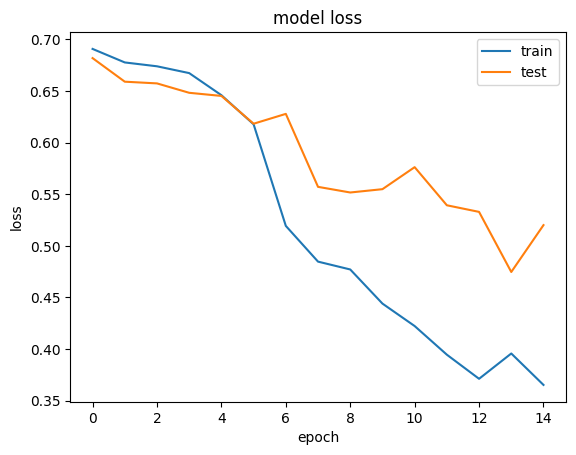

In [432]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

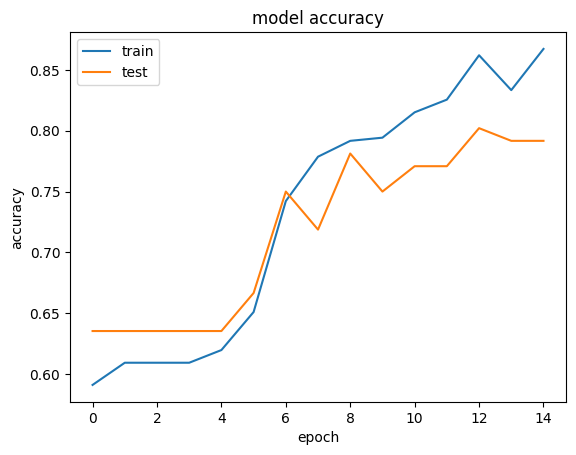

In [433]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [441]:
# assume your new sentence is stored in a variable called new_sentence
new_sent = "I love him"

# preprocess the text
new_sentence = preprocessText(new_sent)

# tokenize and pad the sequence
new_sentence_seq = tokenizer.texts_to_sequences([new_sentence])
new_sentence_padded = pad_sequences(new_sentence_seq, padding='post', maxlen=max_len)

# make prediction
prediction = lstmModel.predict(new_sentence_padded)[0][0]
if prediction >= 0.5:
    print(f" {new_sent}: positive review")
else:
    print(f"{new_sent}: negative review")


1/1 [==============================] - 0s 52ms/step
 I love him: positive review
